In [ ]:
# TensorFlow ve Keras için kurulum
!pip install tensorflow
!pip install keras
!pip install tensorflow-hub

# OpenCV için kurulum
!pip install opencv-python

# PyTorch için kurulum
!pip install torch torchvision

!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install pillow

In [ ]:
!pip install scikit-learn

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramazanfratakda","key":"ed1566cc15f2c7491d66fcf38a8f266b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hamzaboulahia/hardfakevsrealfaces
!unzip hardfakevsrealfaces.zip

Dataset URL: https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces
License(s): CC0-1.0
 33% 5.00M/15.3M [00:00<00:00, 34.1MB/s]
100% 15.3M/15.3M [00:00<00:00, 82.6MB/s]
Archive:  hardfakevsrealfaces.zip
  inflating: data.csv                
  inflating: fake/fake_1.jpg         
  inflating: fake/fake_10.jpg        
  inflating: fake/fake_100.jpg       
  inflating: fake/fake_101.jpg       
  inflating: fake/fake_102.jpg       
  inflating: fake/fake_103.jpg       
  inflating: fake/fake_104.jpg       
  inflating: fake/fake_105.jpg       
  inflating: fake/fake_106.jpg       
  inflating: fake/fake_107.jpg       
  inflating: fake/fake_108.jpg       
  inflating: fake/fake_109.jpg       
  inflating: fake/fake_11.jpg        
  inflating: fake/fake_110.jpg       
  inflating: fake/fake_111.jpg       
  inflating: fake/fake_112.jpg       
  inflating: fake/fake_113.jpg       
  inflating: fake/fake_114.jpg       
  inflating: fake/fake_115.jpg       
  inflating: fake/fake_11

# Kütüphaneleri Ekleme

In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from glob import glob

from tensorflow import keras
from keras import layers
from keras.models import Sequential

# Resimleri içe aktarma

In [ ]:
real_path = './real'
fake_path = './fake'


def load_images_from_dir(path):
  images = []
  filenames = os.listdir(path)

  for file in filenames:
    img = cv2.imread(os.path.join(path,file))

    if img is not None:
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(image)

  return images

def preprocess_images(images, target_size=(224,224),):
    preprocessed_images = []

    for image in images :
      image = cv2.resize(image, target_size)
      image = image / 255 # normalizasyon
      preprocessed_images.append(image)

    return np.array(preprocessed_images)


real_images = load_images_from_dir(real_path)
fake_images = load_images_from_dir(fake_path)

real_preprocessed_images = preprocess_images(real_images)
fake_preprocessed_images = preprocess_images(fake_images)



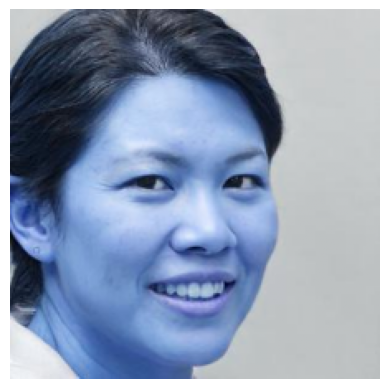

In [ ]:
plt.imshow(fake_preprocessed_images[3])
plt.axis('off')
plt.show()

# Train ve Test verilerine ayırma

In [ ]:
#  gerçek görüntüler için 1, sahte görüntüler için 0
real_labels = [1] * len(real_preprocessed_images)
fake_labels = [0] * len(fake_preprocessed_images)

# Tüm görüntüleri ve etiketleri
all_images = np.concatenate((real_preprocessed_images, fake_preprocessed_images), axis=0)
all_labels = real_labels + fake_labels


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)



print("Train shape: ", X_train.shape, y_train.shape)
print("Validation shape: ", X_val.shape, y_val.shape)
print("Test shape: ", X_test.shape, y_test.shape)

Train shape:  (824, 224, 224, 3) (824,)
Validation shape:  (207, 224, 224, 3) (207,)
Test shape:  (258, 224, 224, 3) (258,)


# Model oluşturma
* Mobilenet v3 small

In [ ]:
mobilenet_small = keras.applications.MobileNetV3Small(
    input_shape=(224, 224,3 ),
   alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    dropout_rate=0.2,
    classifier_activation="sigmoid",
    classes=2,
    input_tensor=None,
    pooling=None,
    include_preprocessing=False,
)

"""for layer in mobilenet_small.layers[:200]:
    layer.trainable = False"""

mobilenet_small.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['input_1[0][0]']             
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                        
                                                                                                  
 tf.__operators__.ad

In [ ]:
small_model = keras.Sequential()
small_model.add(mobilenet_small)
small_model.add(keras.layers.GlobalAveragePooling2D())
small_model.add(keras.layers.Dense(128, activation='relu'))
small_model.add(keras.layers.Dense(64, activation='relu'))
small_model.add(keras.layers.Dense(32, activation='relu'))
small_model.add(keras.layers.Dropout(0.5))
small_model.add(keras.layers.Dense(1, activation='sigmoid'))



small_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0

In [ ]:

optimizer = keras.optimizers.Adam(learning_rate=0.001)

small_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


small_history = small_model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))

test_loss, test_accuracy = small_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/30
26/26 [==============================] - 25s 118ms/step - loss: 0.0167 - accuracy: 0.9976 - val_loss: 0.1421 - val_accuracy: 0.9758
Epoch 2/30
26/26 [==============================] - 2s 59ms/step - loss: 0.0051 - accuracy: 0.9976 - val_loss: 1.4955 - val_accuracy: 0.8889
Epoch 3/30
26/26 [==============================] - 2s 60ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.7701 - val_accuracy: 0.9324
Epoch 4/30
26/26 [==============================] - 2s 60ms/step - loss: 6.5130e-05 - accuracy: 1.0000 - val_loss: 0.5157 - val_accuracy: 0.9469
Epoch 5/30
26/26 [==============================] - 2s 60ms/step - loss: 9.7994e-04 - accuracy: 1.0000 - val_loss: 0.4086 - val_accuracy: 0.9565
Epoch 6/30
26/26 [==============================] - 2s 59ms/step - loss: 0.0260 - accuracy: 0.9976 - val_loss: 0.7041 - val_accuracy: 0.9324
Epoch 7/30
26/26 [==============================] - 2s 59ms/step - loss: 0.0282 - accuracy: 0.9927 - val_loss: 0.0026 - val_accuracy: 1.0000
Epo

9/9 [==============================] - 0s 24ms/step - loss: 1.0113 - accuracy: 0.9729
Test Loss: 1.0112687349319458
Test Accuracy: 0.9728682041168213
9/9 [==============================] - 1s 22ms/step


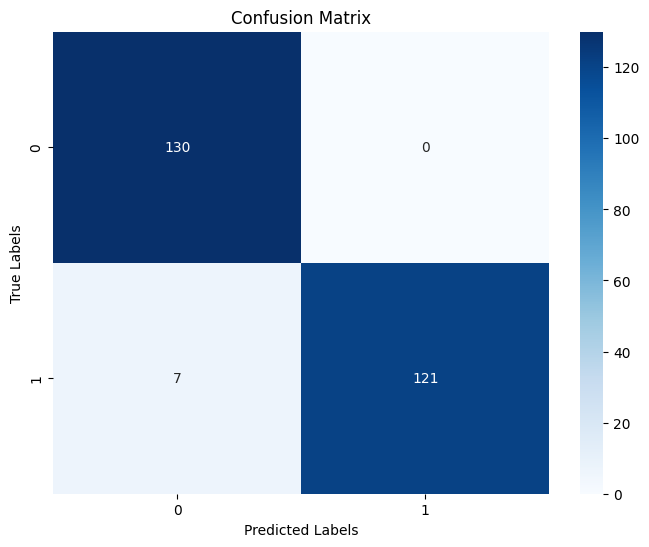

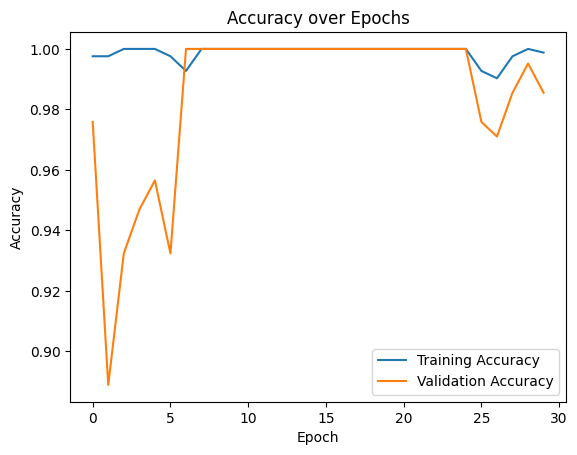

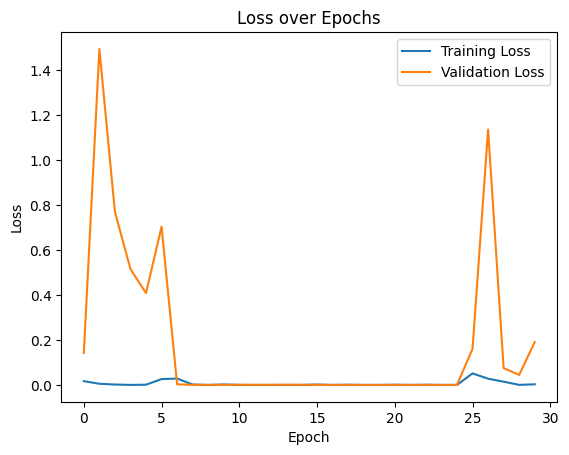

In [ ]:
test_loss, test_accuracy = small_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = small_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(small_history.history['accuracy'], label='Training Accuracy')
plt.plot(small_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(small_history.history['loss'], label='Training Loss')
plt.plot(small_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Modeli kaydetmek
small_model.save('/content/gdrive/My Drive/small_model_hard.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Mobilenet v3 Large

In [ ]:
mobilenet_large = keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    dropout_rate=0.2,
    pooling=None,
    classes=2,  # Sınıf sayısı
    classifier_activation='sigmoid'
)

for layer in mobilenet_large.layers[:250]:
    layer.trainable = False

mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_2[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [ ]:
large_model = keras.Sequential()
large_model.add(mobilenet_large)
large_model.add(keras.layers.Flatten())
large_model.add(keras.layers.Dropout(0.1))
large_model.add(keras.layers.Dense(1, activation='sigmoid'))



large_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 47040)             0         
                                                                 
 dropout_1 (Dropout)         (None, 47040)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 47041     
                                                                 
Total params: 3043393 (11.61 MB)
Trainable params: 356481 (1.36 MB)
Non-trainable params: 2686912 (10.25 MB)
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.00001)

large_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


large_history = large_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

test_loss, test_accuracy = large_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)




Epoch 1/50
26/26 [==============================] - 7s 113ms/step - loss: 0.0243 - accuracy: 0.9951 - val_loss: 0.4761 - val_accuracy: 0.7681
Epoch 2/50
26/26 [==============================] - 1s 50ms/step - loss: 0.0229 - accuracy: 0.9988 - val_loss: 0.4807 - val_accuracy: 0.7440
Epoch 3/50
26/26 [==============================] - 1s 49ms/step - loss: 0.0212 - accuracy: 0.9988 - val_loss: 0.4846 - val_accuracy: 0.7391
Epoch 4/50
26/26 [==============================] - 1s 50ms/step - loss: 0.0213 - accuracy: 0.9976 - val_loss: 0.4713 - val_accuracy: 0.7585
Epoch 5/50
26/26 [==============================] - 1s 49ms/step - loss: 0.0215 - accuracy: 0.9976 - val_loss: 0.4479 - val_accuracy: 0.8164
Epoch 6/50
26/26 [==============================] - 1s 49ms/step - loss: 0.0238 - accuracy: 0.9951 - val_loss: 0.4634 - val_accuracy: 0.7633
Epoch 7/50
26/26 [==============================] - 1s 49ms/step - loss: 0.0236 - accuracy: 0.9976 - val_loss: 0.4410 - val_accuracy: 0.8164
Epoch 8/50
2

9/9 [==============================] - 0s 40ms/step - loss: 0.2671 - accuracy: 0.9031
Test Loss: 0.2671477496623993
Test Accuracy: 0.9031007885932922
9/9 [==============================] - 1s 34ms/step


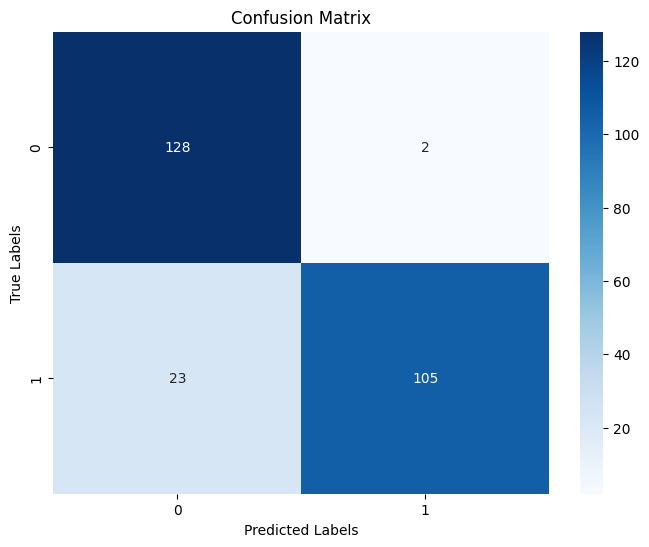

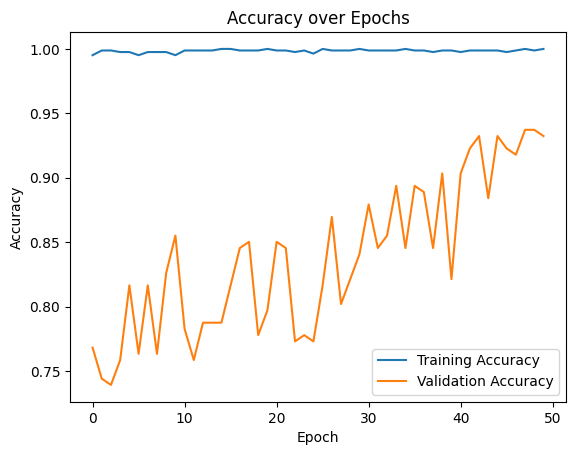

In [ ]:
test_loss, test_accuracy = large_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = large_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(large_history.history['accuracy'], label='Training Accuracy')
plt.plot(large_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Modeli kaydetmek
large_model.save('/content/gdrive/My Drive/large_model_hard.h5')

# yükleme
#loaded_model = keras.models.load_model('/content/gdrive/My Drive/model_kaydi.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Shufflenet

In [ ]:
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import backend as K
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras_applications.imagenet_utils import _obtain_input_shape
#from tensorflow.keras.models import Model


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout

from tensorflow.keras.layers import Activation, Add, Concatenate, GlobalAveragePooling2D,GlobalMaxPooling2D, Input, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Lambda

from tensorflow.keras.utils import get_file
from tensorflow.keras.layers import DepthwiseConv2D
import numpy as np
import numpy as np

from tensorflow.python.keras import backend as K

from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import keras_export

def get_source_inputs(tensor, layer=None, node_index=None):

  if not hasattr(tensor, '_keras_history'):
    return tensor

  if layer is None or node_index:
    layer, node_index, _ = tensor._keras_history
  if not layer._inbound_nodes:
    return [tensor]
  else:
    node = layer._inbound_nodes[node_index]
    if not node.inbound_layers:
      # Reached an Input layer, stop recursion.
      return nest.flatten(node.input_tensors)
    else:
      source_tensors = []
      for layer, node_index, _, tensor in node.iterate_inbound():
        previous_sources = get_source_inputs(tensor, layer, node_index)
        # Avoid input redundancy.
        for x in previous_sources:
          if x not in source_tensors:
            source_tensors.append(x)
      return source_tensors

def ShuffleNet(include_top=True, input_tensor=None, scale_factor=1.0, pooling='max',weights = None,
               input_shape=(224,224,3), groups=1, load_model=None, num_shuffle_units=[3, 7, 3],
               bottleneck_ratio=0.25, classes=1000):

    if K.backend() != 'tensorflow':
        raise RuntimeError('Only TensorFlow backend is currently supported, '
                           'as other backends do not support ')

    name = "ShuffleNet_%.2gX_g%d_br_%.2g_%s" % (scale_factor, groups, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)


    out_dim_stage_two = {1: 144, 2: 200, 3: 240, 4: 272, 8: 384}
    if groups not in out_dim_stage_two:
        raise ValueError("Invalid number of groups.")

    if pooling not in ['max','avg']:
        raise ValueError("Invalid value for pooling.")

    if not (float(scale_factor) * 4).is_integer():
        raise ValueError("Invalid value for scale_factor. Should be x over 4.")

    exp = np.insert(np.arange(0, len(num_shuffle_units), dtype=np.float32), 0, 0)
    out_channels_in_stage = 2 ** exp
    out_channels_in_stage *= out_dim_stage_two[groups]  # calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same',
               use_bias=False, strides=(2, 2), activation="relu", name="conv1")(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name="maxpool1")(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(0, len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = _block(x, out_channels_in_stage, repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   groups=groups, stage=stage + 2)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name="global_pool")(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name="global_pool")(x)

    if include_top:
        x = Dense(units=classes, name="fc")(x)
        x = Activation('softmax', name='softmax')(x)


    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs=inputs, outputs=x, name=name)

    if load_model is not None:
        model.load_weights('', by_name=True)

    return model


def _block(x, channel_map, bottleneck_ratio, repeat=1, groups=1, stage=1):

    x = _shuffle_unit(x, in_channels=channel_map[stage - 2],
                      out_channels=channel_map[stage - 1], strides=2,
                      groups=groups, bottleneck_ratio=bottleneck_ratio,
                      stage=stage, block=1)

    for i in range(1, repeat + 1):
        x = _shuffle_unit(x, in_channels=channel_map[stage - 1],
                          out_channels=channel_map[stage - 1], strides=1,
                          groups=groups, bottleneck_ratio=bottleneck_ratio,
                          stage=stage, block=(i + 1))

    return x


def _shuffle_unit(inputs, in_channels, out_channels, groups, bottleneck_ratio, strides=2, stage=1, block=1):

    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        bn_axis = 1

    prefix = 'stage%d/block%d' % (stage, block)

    #if strides >= 2:
        #out_channels -= in_channels

    # default: 1/4 of the output channel of a ShuffleNet Unit
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    groups = (1 if stage == 2 and block == 1 else groups)

    x = _group_conv(inputs, in_channels, out_channels=bottleneck_channels,
                    groups=(1 if stage == 2 and block == 1 else groups),
                    name='%s/1x1_gconv_1' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_1' % prefix)(x)
    x = Activation('relu', name='%s/relu_gconv_1' % prefix)(x)

    x = Lambda(channel_shuffle, arguments={'groups': groups}, name='%s/channel_shuffle' % prefix)(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), padding="same", use_bias=False,
                        strides=strides, name='%s/1x1_dwconv_1' % prefix)(x)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_dwconv_1' % prefix)(x)

    x = _group_conv(x, bottleneck_channels, out_channels=out_channels if strides == 1 else out_channels - in_channels,
                    groups=groups, name='%s/1x1_gconv_2' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_2' % prefix)(x)

    if strides < 2:
        ret = Add(name='%s/add' % prefix)([x, inputs])
    else:
        avg = AveragePooling2D(pool_size=3, strides=2, padding='same', name='%s/avg_pool' % prefix)(inputs)
        ret = Concatenate(bn_axis, name='%s/concat' % prefix)([x, avg])

    ret = Activation('relu', name='%s/relu_out' % prefix)(ret)

    return ret


def _group_conv(x, in_channels, out_channels, groups, kernel=1, stride=1, name=''):

    if groups == 1:
        return Conv2D(filters=out_channels, kernel_size=kernel, padding='same',
                      use_bias=False, strides=stride, name=name)(x)

    # number of intput channels per group
    ig = in_channels // groups
    group_list = []

    assert out_channels % groups == 0

    for i in range(groups):
        offset = i * ig
        group = Lambda(lambda z: z[:, :, :, offset: offset + ig], name='%s/g%d_slice' % (name, i))(x)
        group_list.append(Conv2D(int(0.5 + out_channels / groups), kernel_size=kernel, strides=stride,
                                 use_bias=False, padding='same', name='%s_/g%d' % (name, i))(group))
    return Concatenate(name='%s/concat' % name)(group_list)


def channel_shuffle(x, groups):

    height, width, in_channels = x.shape.as_list()[1:]
    channels_per_group = in_channels // groups

    x = K.reshape(x, [-1, height, width, groups, channels_per_group])
    x = K.permute_dimensions(x, (0, 1, 2, 4, 3))  # transpose
    x = K.reshape(x, [-1, height, width, in_channels])

    return x


In [ ]:
shufflenet_model = ShuffleNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


shufflenet_model.summary()

Model: "ShuffleNet_1X_g1_br_0.25_373"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 24)         648       ['input_4[0][0]']             
                                                                                                  
 maxpool1 (MaxPooling2D)     (None, 56, 56, 24)           0         ['conv1[0][0]']               
                                                                                                  
 stage2/block1/1x1_gconv_1   (None, 56, 56, 36)           864       ['maxpool1[0][0]']            
 (Conv2D)                                                              

In [ ]:
shuffle_model = keras.models.Sequential()
shuffle_model.add(shufflenet_model)  # Shufflenet modeli
shuffle_model.add(keras.layers.Flatten())  # Flatten katmanı
shuffle_model.add(keras.layers.Dense(256, activation='relu'))
shuffle_model.add(keras.layers.Dropout(0.3))
shuffle_model.add(keras.layers.Dense(1, activation='sigmoid'))  # Çıkış katmanı

In [ ]:
shuffle_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


shuffle_history = shuffle_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

test_loss, test_accuracy = shuffle_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/50
26/26 [==============================] - 25s 116ms/step - loss: 0.0102 - accuracy: 0.9951 - val_loss: 0.8118 - val_accuracy: 0.8792
Epoch 2/50
26/26 [==============================] - 1s 56ms/step - loss: 0.0478 - accuracy: 0.9903 - val_loss: 0.0531 - val_accuracy: 0.9807
Epoch 3/50
26/26 [==============================] - 1s 58ms/step - loss: 0.0702 - accuracy: 0.9830 - val_loss: 1.8495 - val_accuracy: 0.6715
Epoch 4/50
26/26 [==============================] - 1s 56ms/step - loss: 0.0136 - accuracy: 0.9951 - val_loss: 0.2099 - val_accuracy: 0.9469
Epoch 5/50
26/26 [==============================] - 1s 57ms/step - loss: 0.0026 - accuracy: 0.9988 - val_loss: 0.0157 - val_accuracy: 0.9952
Epoch 6/50
26/26 [==============================] - 1s 56ms/step - loss: 1.8188e-04 - accuracy: 1.0000 - val_loss: 4.4436e-05 - val_accuracy: 1.0000
Epoch 7/50
26/26 [==============================] - 1s 57ms/step - loss: 3.8415e-04 - accuracy: 1.0000 - val_loss: 3.0755e-06 - val_accuracy: 1.

9/9 [==============================] - 0s 23ms/step - loss: 1.3795e-05 - accuracy: 1.0000
Test Loss: 1.379532022838248e-05
Test Accuracy: 1.0
9/9 [==============================] - 1s 20ms/step


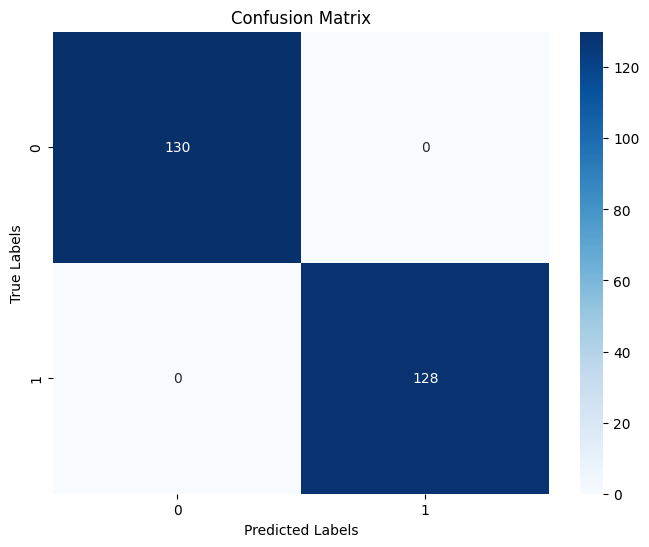

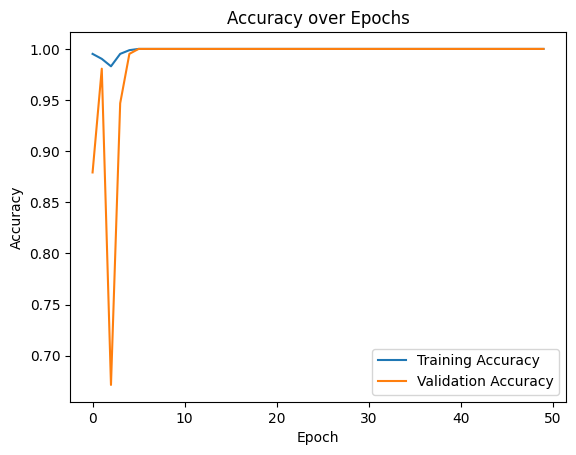

In [ ]:
test_loss, test_accuracy = shuffle_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = shuffle_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(shuffle_history.history['accuracy'], label='Training Accuracy')
plt.plot(shuffle_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(small_history.history['loss'], label='Training Loss')
plt.plot(small_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Modeli kaydetmek
large_model.save('/content/gdrive/My Drive/shuffle_model_hard.h5')

# yükleme
#loaded_model = keras.models.load_model('/content/gdrive/My Drive/model_kaydi.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# SqueezeNet

In [ ]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.utils import get_file
#from keras.utils import layer_utils

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                     require_flatten = False)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='squeezenet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [ ]:
squeeeze = SqueezeNet(weights='imagenet',input_shape=(224,224,3))

"""for layer in squeeeze.layers[:50]:
    layer.trainable = False"""
squeeeze.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 111, 111, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 relu_conv1 (Activation)     (None, 111, 111, 64)         0         ['conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 55, 55, 64)           0         ['relu_conv1[0][0]']          
                                                                                         

In [ ]:
squeeze_model = keras.models.Sequential()
squeeze_model.add(squeeeze)
squeeze_model.add(keras.layers.Flatten())
squeeze_model.add(keras.layers.Dense(64, activation='relu'))
#squeeze_model.add(keras.layers.Dropout(0.2))
squeeze_model.add(keras.layers.Dense(1, activation='sigmoid'))

squeeze_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 squeezenet (Functional)     (None, 1000)              1235496   
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 64)                64064     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1299625 (4.96 MB)
Trainable params: 1299625 (4.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)


squeeze_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

squeeze_history = squeeze_model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val))

test_loss,test_accuracy = squeeze_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/50
26/26 [==============================] - 17s 171ms/step - loss: 0.6825 - accuracy: 0.7985 - val_loss: 0.6703 - val_accuracy: 0.9565
Epoch 2/50
26/26 [==============================] - 2s 61ms/step - loss: 0.6657 - accuracy: 0.9454 - val_loss: 0.6582 - val_accuracy: 0.9758
Epoch 3/50
26/26 [==============================] - 2s 61ms/step - loss: 0.6522 - accuracy: 0.9867 - val_loss: 0.6458 - val_accuracy: 0.9855
Epoch 4/50
26/26 [==============================] - 2s 61ms/step - loss: 0.6407 - accuracy: 0.9915 - val_loss: 0.6354 - val_accuracy: 0.9855
Epoch 5/50
26/26 [==============================] - 2s 62ms/step - loss: 0.6303 - accuracy: 0.9951 - val_loss: 0.6256 - val_accuracy: 0.9903
Epoch 6/50
26/26 [==============================] - 2s 62ms/step - loss: 0.6203 - accuracy: 0.9964 - val_loss: 0.6157 - val_accuracy: 0.9903
Epoch 7/50
26/26 [==============================] - 2s 61ms/step - loss: 0.6106 - accuracy: 0.9988 - val_loss: 0.6075 - val_accuracy: 0.9903
Epoch 8/50


9/9 [==============================] - 0s 24ms/step - loss: 0.2080 - accuracy: 1.0000
Test Loss: 0.20802730321884155
Test Accuracy: 1.0
9/9 [==============================] - 0s 22ms/step


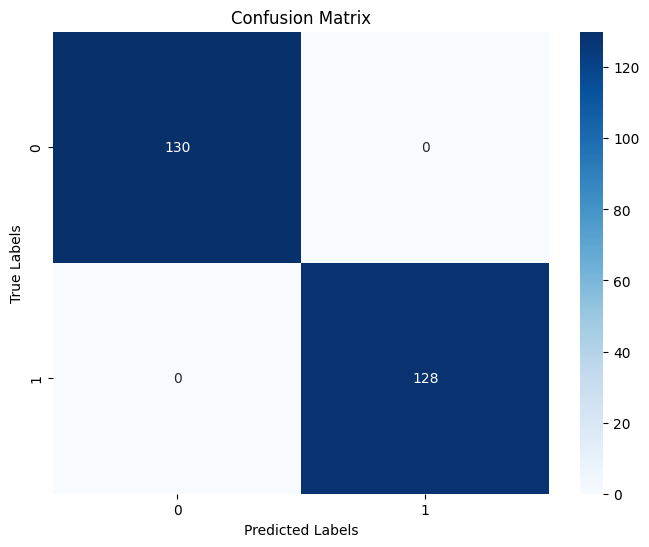

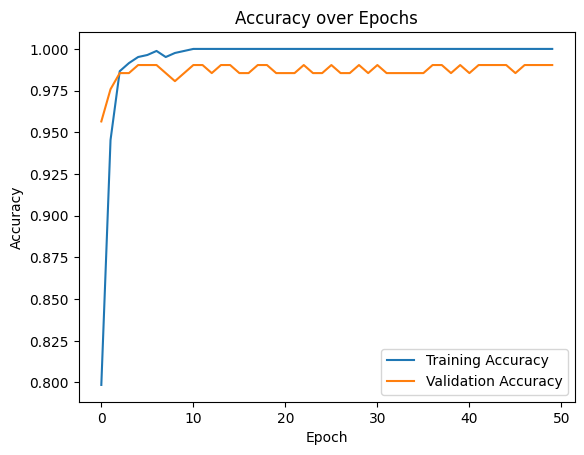

In [ ]:
test_loss, test_accuracy = squeeze_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = squeeze_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(squeeze_history.history['accuracy'], label='Training Accuracy')
plt.plot(squeeze_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Modeli kaydetmek
squeeze_model.save('/content/gdrive/My Drive/squeeze_model_hard.h5')

Mounted at /content/gdrive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# VGG

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
vgg_model = keras.models.Sequential()
vgg_model.add(vgg)
vgg_model.add(keras.layers.Flatten())
vgg_model.add(keras.layers.Dense(64, activation='relu'))
vgg_model.add(keras.layers.Dense(1, activation='sigmoid'))

vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                1605696   
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16320449 (62.26 MB)
Trainable params: 1605761 (6.13 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)


vgg_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
vgg_history = vgg_model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val))

test_loss, test_accuracy = vgg_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/50
26/26 [==============================] - 20s 511ms/step - loss: 0.2717 - accuracy: 0.9078 - val_loss: 0.0501 - val_accuracy: 0.9952
Epoch 2/50
26/26 [==============================] - 4s 150ms/step - loss: 0.0361 - accuracy: 0.9964 - val_loss: 0.0224 - val_accuracy: 1.0000
Epoch 3/50
26/26 [==============================] - 4s 150ms/step - loss: 0.0180 - accuracy: 0.9976 - val_loss: 0.0182 - val_accuracy: 0.9952
Epoch 4/50
26/26 [==============================] - 4s 151ms/step - loss: 0.0117 - accuracy: 0.9988 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 5/50
26/26 [==============================] - 4s 153ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9952
Epoch 6/50
26/26 [==============================] - 4s 153ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 0.9952
Epoch 7/50
26/26 [==============================] - 4s 153ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.9952
Epoch

9/9 [==============================] - 1s 107ms/step - loss: 0.0020 - accuracy: 1.0000
Test Loss: 0.00199678516946733
Test Accuracy: 1.0
9/9 [==============================] - 1s 115ms/step


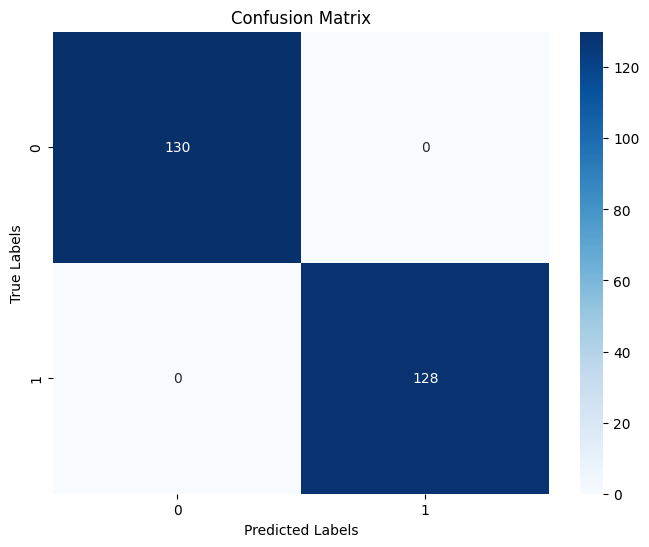

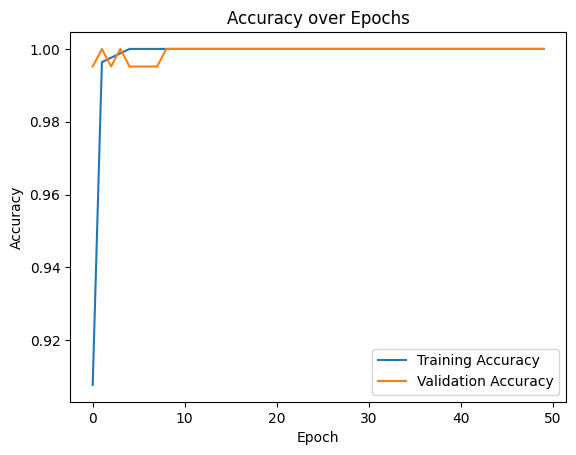

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = vgg_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(vgg_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()



In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

vgg_model.save('/content/gdrive/My Drive/vgg_model_hard.h5')

Mounted at /content/gdrive


# SQUEEEZENET İLE SHUFFLENET BİRLEŞTİRME

In [ ]:
shuffle_loaded_model = keras.models.load_model('/content/gdrive/My Drive/shuffle_model_hard.h5')
squeeze_loaded_model = keras.models.load_model('/content/gdrive/My Drive/squeeze_model_hard.h5')

In [ ]:
from keras.layers import Concatenate
output = Concatenate()([keras.layers.Flatten()(shuffle_loaded_model.output), keras.layers.Flatten()(squeeze_loaded_model.output)])

output = keras.layers.Dropout(0.8)(output)
output = keras.layers.Dense(1, activation='sigmoid')(output)

concat_model = Model(inputs = [shuffle_loaded_model.input, squeeze_loaded_model.input], outputs = output)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
concat_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
concat_model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 MobilenetV3large_input (In  [(None, 224, 224, 3)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 squeezenet_input (InputLay  [(None, 224, 224, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['MobilenetV3large_input[0][0]
 al)                                                                ']                      

In [ ]:
concat_history = concat_model.fit([X_train, X_train], y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=([X_val, X_val], y_val))

test_loss,test_accuracy = concat_model.evaluate([X_test, X_test], y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/50
26/26 [==============================] - 17s 188ms/step - loss: 0.7883 - accuracy: 0.5522 - val_loss: 0.5674 - val_accuracy: 0.9082
Epoch 2/50
26/26 [==============================] - 3s 100ms/step - loss: 0.6658 - accuracy: 0.5862 - val_loss: 0.5110 - val_accuracy: 0.9758
Epoch 3/50
26/26 [==============================] - 3s 101ms/step - loss: 0.6477 - accuracy: 0.5934 - val_loss: 0.5119 - val_accuracy: 0.9855
Epoch 4/50
26/26 [==============================] - 3s 101ms/step - loss: 0.6604 - accuracy: 0.5874 - val_loss: 0.5245 - val_accuracy: 0.9662
Epoch 5/50
26/26 [==============================] - 3s 101ms/step - loss: 0.6484 - accuracy: 0.5862 - val_loss: 0.4921 - val_accuracy: 0.9903
Epoch 6/50
26/26 [==============================] - 3s 102ms/step - loss: 0.6469 - accuracy: 0.6201 - val_loss: 0.4984 - val_accuracy: 0.9855
Epoch 7/50
26/26 [==============================] - 3s 102ms/step - loss: 0.6634 - accuracy: 0.6129 - val_loss: 0.5349 - val_accuracy: 0.9275
Epoch

9/9 [==============================] - 1s 54ms/step - loss: 0.4699 - accuracy: 0.9690
Test Loss: 0.46994104981422424
Test Accuracy: 0.9689922332763672
9/9 [==============================] - 2s 55ms/step


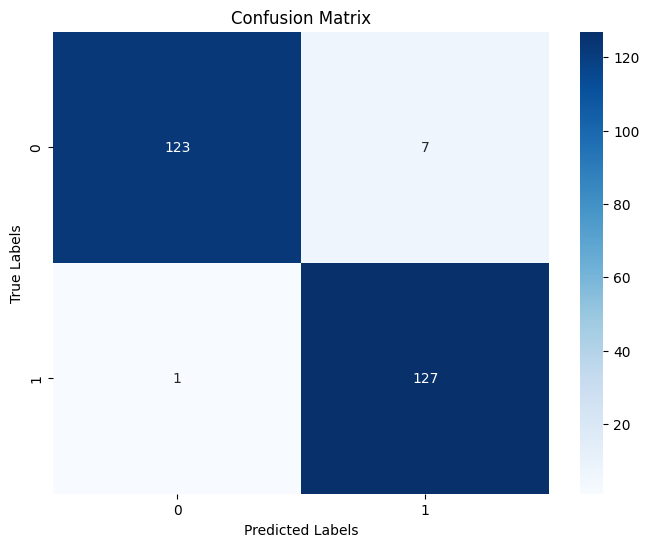

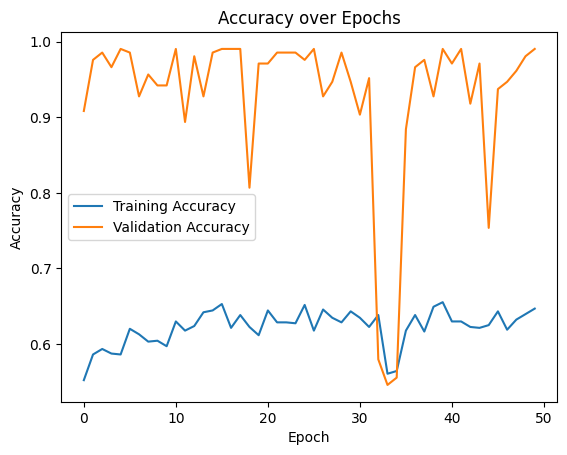

In [ ]:
test_loss, test_accuracy = concat_model.evaluate([X_test,X_test], y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = concat_model.predict([X_test,X_test])
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(concat_history.history['accuracy'], label='Training Accuracy')
plt.plot(concat_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


# Loss grafiğini çizdir
plt.plot(concat_history.history['loss'], label='Training Loss')
plt.plot(concat_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Modeli kaydetmek
concat_model.save('/content/gdrive/My Drive/concat_model_hard.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# VGG ile SQUEEEZENET Birleştirme

In [ ]:
shuffle_loaded_model = keras.models.load_model('/content/gdrive/My Drive/shuffle_model_hard.h5')
vgg_loaded_model = keras.models.load_model('/content/gdrive/My Drive/vgg_model_hard.h5')


In [ ]:
from keras.layers import Concatenate


for layer in vgg_loaded_model.layers:
    layer._name = f'vgg_{layer.name}'

for layer in shuffle_loaded_model.layers:
    layer._name = f'shuffle_{layer.name}'

output = Concatenate()([
    keras.layers.Flatten()(shuffle_loaded_model.output),
    keras.layers.Flatten()(vgg_loaded_model.output)
])

output = keras.layers.Dropout(0.5)(output)
output = keras.layers.Dense(1, activation='sigmoid', name='output')(output)

# Define the concatenated model with custom layer names
concat_model2 = Model(inputs=[shuffle_loaded_model.input, vgg_loaded_model.input], outputs=output)

#concat_model2 = Model(inputs = [vgg_loaded_model.input,shuffle_loaded_model.input], outputs = output)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
concat_model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
concat_model2.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 MobilenetV3large_input (In  [(None, 224, 224, 3)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 vgg16_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 shuffle_MobilenetV3large (  (None, 7, 7, 960)            2996352   ['MobilenetV3large_input[0][0]
 Functional)                                                        ']                            
                                                                                           

In [ ]:
concat_history2 = concat_model2.fit([X_train, X_train], y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=([X_val, X_val], y_val))

test_loss,test_accuracy = concat_model2.evaluate([X_test, X_test], y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/50
26/26 [==============================] - 12s 270ms/step - loss: 0.6341 - accuracy: 0.6796 - val_loss: 0.5619 - val_accuracy: 0.9903
Epoch 2/50
26/26 [==============================] - 5s 190ms/step - loss: 0.6402 - accuracy: 0.7039 - val_loss: 0.5578 - val_accuracy: 0.9903
Epoch 3/50
26/26 [==============================] - 5s 190ms/step - loss: 0.6305 - accuracy: 0.7269 - val_loss: 0.5488 - val_accuracy: 0.9855
Epoch 4/50
26/26 [==============================] - 5s 191ms/step - loss: 0.6138 - accuracy: 0.7209 - val_loss: 0.5344 - val_accuracy: 0.9710
Epoch 5/50
26/26 [==============================] - 5s 191ms/step - loss: 0.5890 - accuracy: 0.7245 - val_loss: 0.5238 - val_accuracy: 0.9614
Epoch 6/50
26/26 [==============================] - 5s 190ms/step - loss: 0.5956 - accuracy: 0.7172 - val_loss: 0.5184 - val_accuracy: 0.9469
Epoch 7/50
26/26 [==============================] - 5s 190ms/step - loss: 0.5849 - accuracy: 0.7209 - val_loss: 0.5156 - val_accuracy: 0.9517
Epoch

9/9 [==============================] - 1s 132ms/step - loss: 0.4934 - accuracy: 0.9767
Test Loss: 0.49337998032569885
Test Accuracy: 0.9767441749572754
9/9 [==============================] - 2s 152ms/step


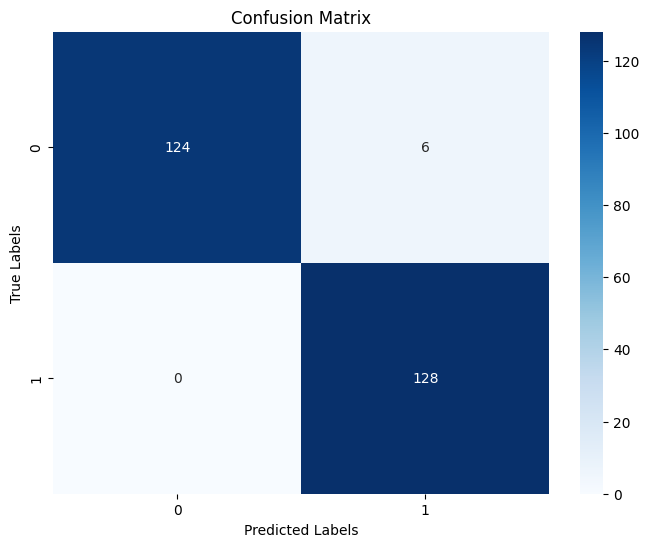

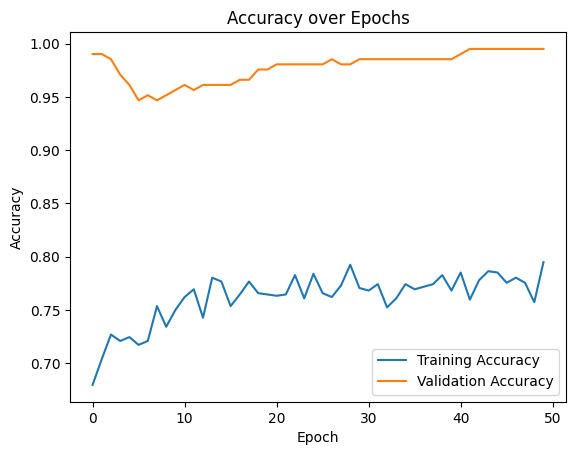

In [ ]:
test_loss, test_accuracy = concat_model2.evaluate([X_test,X_test], y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = concat_model2.predict([X_test,X_test])
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(concat_history2.history['accuracy'], label='Training Accuracy')
plt.plot(concat_history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

Mobilenet 1. veri seti ile mobilenet 2. veri seti birleştirme


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
small_easy_model = keras.models.load_model('/content/gdrive/My Drive/small_model_hard.h5')
small_hard_model = keras.models.load_model('/content/gdrive/My Drive/small_model_easy.h5')

small_easy_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0

In [ ]:

small_easy_model.summary()
small_hard_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 easy_MobilenetV3small (Fun  (None, 7, 7, 576)         939120    
 ctional)                                                        
                                                                 
 easy_global_average_poolin  (None, 576)               0         
 g2d (GlobalAveragePooling2                                      
 D)                                                              
                                                                 
 easy_dense (Dense)          (None, 128)               73856     
                                                                 
 easy_dense_1 (Dense)        (None, 64)                8256      
                                                                 
 easy_dense_2 (Dense)        (None, 32)                2080      
                                                        

In [ ]:

for layer in small_easy_model.layers:
    layer._name = f'easy_{layer.name}'

for layer in small_hard_model.layers:
    layer._name = f'hard_{layer.name}'


input_easy = Input(tensor=small_easy_model.input, name='unique_easy_input')
input_hard = Input(tensor=small_hard_model.input, name='unique_hard_input')


easy_flatten = Flatten()(small_easy_model.output)
hard_flatten = Flatten()(small_hard_model.output)


concatenated = Concatenate()([easy_flatten, hard_flatten])


dropout = Dropout(0.8)(concatenated)
output = Dense(1, activation='sigmoid')(dropout)

concat_model = Model(inputs=[input_easy, input_hard], outputs=output)






In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
concat_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

concat_history = concat_model.fit([X_train, X_train], y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=([X_val, X_val], y_val))

test_loss,test_accuracy = concat_model.evaluate([X_test, X_test], y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/50
26/26 [==============================] - 61s 403ms/step - loss: 0.6530 - accuracy: 0.6250 - val_loss: 0.6375 - val_accuracy: 0.9952
Epoch 2/50
26/26 [==============================] - 3s 112ms/step - loss: 0.6446 - accuracy: 0.6396 - val_loss: 0.6328 - val_accuracy: 0.9952
Epoch 3/50
26/26 [==============================] - 3s 112ms/step - loss: 0.6454 - accuracy: 0.6323 - val_loss: 0.6298 - val_accuracy: 0.9952
Epoch 4/50
26/26 [==============================] - 3s 113ms/step - loss: 0.6291 - accuracy: 0.6493 - val_loss: 0.6264 - val_accuracy: 0.9952
Epoch 5/50
26/26 [==============================] - 3s 115ms/step - loss: 0.6354 - accuracy: 0.6468 - val_loss: 0.6226 - val_accuracy: 0.9952
Epoch 6/50
26/26 [==============================] - 3s 114ms/step - loss: 0.6265 - accuracy: 0.6553 - val_loss: 0.6195 - val_accuracy: 0.9952
Epoch 7/50
26/26 [==============================] - 3s 114ms/step - loss: 0.6351 - accuracy: 0.6383 - val_loss: 0.6179 - val_accuracy: 0.9952
Epoch

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = concat_model.evaluate([X_test,X_test], y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = concat_model.predict([X_test,X_test])
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(concat_history.history['accuracy'], label='Training Accuracy')
plt.plot(concat_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(concat_history.history['loss'], label='Training Loss')
plt.plot(concat_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()